In [1]:
## Download the GloVe word embeddings files from https://nlp.stanford.edu/projects/glove/
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

## Download the Word2vec word embddings file from https://code.google.com/archive/p/word2vec/
# !wget https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

# Twitter US Airline Sentiment
## Analyze how travelers in February 2015 expressed their feelings on Twitter

---

A Natural Language Processing task using the [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) from Kaggle.

The task consists in classifying how travelers expressed their feelings on Twitter into three classes: neutral, positive and negative.



## Loading useful libraries and modules


In [2]:
import os
import random
import re
import string

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

import spacy
from spacy.lang.en import English

from gensim.models import KeyedVectors

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pprint import pprint
from tqdm import tqdm
import contractions

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# Downloads from NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Me\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Me\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the data and performing exploratory data analysis

In [3]:
data = pd.read_csv('Tweets.csv', usecols=['airline_sentiment', 'text'])
data = data.loc[:, ['text', 'airline_sentiment']]
data.rename(columns={'text': 'raw_text', 'airline_sentiment': 'sentiment'}, inplace=True)

In [4]:
data.head()

,raw_text,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


In [5]:
print(f'This dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

This dataset has 14640 rows and 2 columns.


In [6]:
# Show a concise summary of the dataset
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raw_text   14640 non-null  object
 1   sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 3.3 MB


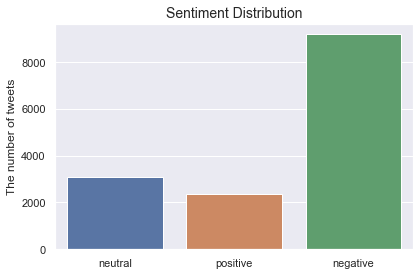

In [7]:
# Plot the target distribution
sns.set()
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution', fontsize=14)
plt.xlabel(None)
plt.ylabel("The number of tweets")
plt.tight_layout();

## Preprocessing the raw data

* Removing urls, hashtags, emails
* Expanding english contractions
* Removing numbers
* Tokenizing sentences
* Removing handles
* Lowercasing
* Removing stop words, punctuation
* Lemmatization, stemming

In [8]:
# Add more contractions
contractions.add('hr', 'hour')
contractions.add('hrs', 'hours')
contractions.add('thx', 'thanks')
contractions.add('thankyou', 'thanks')
contractions.add('badcustomerservice', 'bad customer service')


# Load SpaCy English model
nlp = English()


# Regular expressions
remove_urls     = re.compile(r'https?://\S+|www\.\S+') # Ignore case sensitive
remove_hashtags = re.compile(r'#')
remove_emails   = re.compile(r'\S+@\S+')
remove_rt       = re.compile(r'^RT[\s]+', flags=re.I)
remove_numbers  = re.compile(r'\d+')


def preprocess(text):

    # Parse HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # # Apply regex
    text = remove_urls.sub('', text)        # remove urls
    text = remove_hashtags.sub('', text)    # remove hashtags    
    text = remove_emails.sub('', text)      # remove e-mails
    text = remove_rt.sub('', text)          # remove RT
    text = remove_numbers.sub('', text)     # remove numbers 
    
    # Expand english contractions
    text = contractions.fix(text)

    # Tokenize, lowercase, remove handles
    tt = TweetTokenizer(preserve_case=False,    # lowercasing
                        strip_handles=True,  # remove handles
                        reduce_len=True)     
    
    tokens = tt.tokenize(text)
    
    # Remove stop words
    english_stop_words = stopwords.words('english')
    tokens = [word for word in tokens if (word not in english_stop_words)]
    
    # Remove punctuations
    punctuation = string.punctuation + '-' + '—' + '’' + '“' + '”' + "'" 
    tokens = [word for word in tokens if word not in punctuation]
    
    ### SpaCy
    # Normalize
    text = ' '.join(tokens)
    doc = nlp(text)
    
    tokens = [token.norm_ for token in doc if (not token.is_stop) and (not token.is_punct)]

    ## Lemmatization
    text = ' '.join(tokens)
    doc = nlp(text)
    
    tokens = [token.lemma_ if (token.lemma_ != '-PRON-') else token for token in doc]    

    # Remove no alphabetical and single chars
    tokens = [word for word in tokens if word.isalpha() and (len(word) > 1)]

    return ' '.join(tokens)

In [9]:
%%time
data['text'] = data['raw_text'].apply(preprocess)

Wall time: 9.94 s


In [10]:
# Creat a "word count" column from the preprocessed text
data['word_count'] = data['text'].apply(lambda row: len(row.strip().split()))

In [11]:
data.head()

,raw_text,sentiment,text,word_count
0,@VirginAmerica What @dhepburn said.,neutral,say,1
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,plus add commercial experience tacky,5
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,today mean need trip,4
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,aggressive blast obnoxious entertainment guest face little recourse,8
4,@VirginAmerica and it's a really big bad thing about it,negative,big bad thing,3


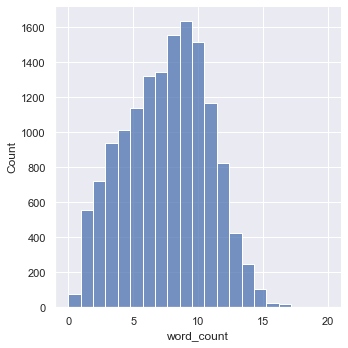

In [12]:
bins = len(set(data['word_count']))
sns.displot(x='word_count', data=data, bins=bins)
plt.tight_layout();

In [13]:
# Compute the word frequency
corpus = ' '.join(data['text'])
freq_dist = nltk.FreqDist(TweetTokenizer().tokenize(corpus))

In [14]:
print(f'The dataset has {len(freq_dist)} unique words')
print('---\n')

# Show the thirty most common words 
pprint(freq_dist.most_common(30), compact=True)

The dataset has 8679 unique words
---

[('flight', 4602), ('thank', 1806), ('hour', 1595), ('cancel', 1064),
 ('service', 1020), ('delay', 1008), ('time', 973), ('customer', 956),
 ('help', 952), ('fly', 783), ('get', 781), ('bag', 769), ('wait', 752),
 ('plane', 732), ('hold', 718), ('need', 687), ('try', 585), ('day', 576),
 ('airline', 556), ('gate', 543), ('seat', 518), ('book', 515),
 ('flightled', 507), ('tell', 493), ('go', 492), ('check', 474),
 ('change', 468), ('phone', 458), ('know', 443), ('like', 434)]


In [15]:
# Compute the rare words frequency
rare_words = [name for name, freq in freq_dist.items() if freq == 1] 
print(f'This dataset has {len(rare_words)} words that occur just one time.')

This dataset has 4446 words that occur just one time.


In [16]:
# %%time
# ## Remove rare words from dataset
# data['text'] = data['text'].apply(lambda row: ' '.join([word for word in row.split() if word not in rare_words]))

# # Update "word_count" column
# data['word_count'] = data['text'].apply(lambda row: len(row.strip().split()))

# data.head(4)

## Handling missing data

In [17]:
# find missing values
print(f'The data shape before dealing with missing data: {data.shape}', '---', sep='\n')
data.loc[data['word_count'] == 0].head()

The data shape before dealing with missing data: (14640, 4)
---


,raw_text,sentiment,text,word_count
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,,0
269,@VirginAmerica I see what you did there ;),positive,,0
669,@united Done and done,neutral,,0
781,@united you too!,positive,,0
988,@united done,neutral,,0


In [18]:
# Replace empty "text" by NaN
data.loc[data['word_count'] == 0, 'text'] = np.nan

# Show where the missing values are 
data.isna().sum()

raw_text       0
sentiment      0
text          74
word_count     0
dtype: int64

In [19]:
# Drop missing values
data.dropna(inplace=True)
print(f'The data shape after dealing with missing data: {data.shape}', '---', sep='\n')
data.isna().sum()

The data shape after dealing with missing data: (14566, 4)
---


raw_text      0
sentiment     0
text          0
word_count    0
dtype: int64

In [20]:
# Update "word_count" column
data['word_count'] = data['text'].apply(lambda row: len(row.strip().split()))

In [21]:
data.sort_values(by='word_count', ascending=False).head()

,raw_text,sentiment,text,word_count
14427,@AmericanAir aftr 10 hrs bng held hstg at mia bc aa refsd to get med bags. bag fnd aa then refsd to fix tkts they cnceld said $360 to fly,negative,aftr hour bng hold hstg mia bc aa refsd med bag bag fnd aa refsd fix tkts cnceld say fly,20
3994,"@united rude cust ser agents busy chatting, then yelled bc I took pic. Put me stdby when seat. Diff agent gave me seat 30min Late Flightr. Platinum",negative,rude cust ser agent busy chat yell bc take pic stdby seat diff agent give seat min late flightr platinum,20
826,@united UA938 ORD-LHR. bags are being loaded 30min Late Flight. Frigid air into cabin! Plane feels like falling apart! Upgrade long haul fleet!,negative,ua ord lhr bag load min late flight frigid air cabin plane feel like fall apart upgrade long haul fleet,20
3697,@united Tks for reply. PSP employees blamed Late Flight departure on POTUS when main reasons were DVR flt Late Flight &amp; insufficient ground crew to handle,negative,tks reply psp employee blame late flight departure potus main reason dvr flt late flight insufficient grind crow handle,19
9537,"@USAirways Customer service is dead. Last wk, flts delayed/Cancelled Flighted. Bags lost 4 days. Last nt, flt delayed/Cancelled Flighted. No meal voucher?",negative,customer service dead wk flts delay cancel flighted bag lose day not flt delay cancel flighted meal voucher,18


## Word cloud

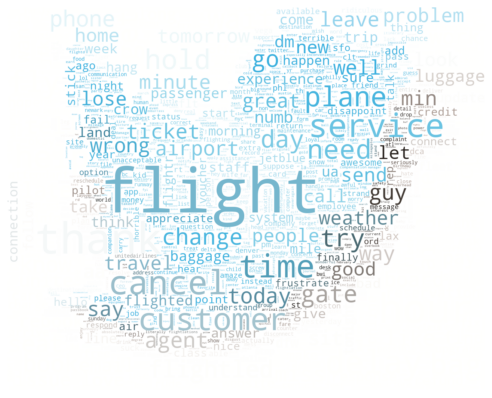

In [22]:
mask = np.array(Image.open('./twitter_img_03.jpg'))

word_cloud = WordCloud(background_color='white',
                       mask=mask,
                       max_words=2000,
                       random_state=0)

word_cloud.fit_words(freq_dist)

image_colors = ImageColorGenerator(mask)

plt.figure(figsize=(7, 7))
plt.imshow(word_cloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.tight_layout();

# plt.savefig('twitter_sentiment_analisys.jpg')

## Preparing the data

In [23]:
# Remove samples with less than four words
data_reduced = data.loc[data['word_count'] > 5].copy()
data_reduced.shape

(10194, 4)

In [24]:
X = data_reduced.loc[:, ['text', 'word_count']]
y = data_reduced['sentiment']

# X = data.loc[:, ['text', 'word_count']]
# y = data['sentiment']

In [25]:
# Split data into 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=0)

# Check dimensions
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8155, 2), (8155,), (2039, 2), (2039,))

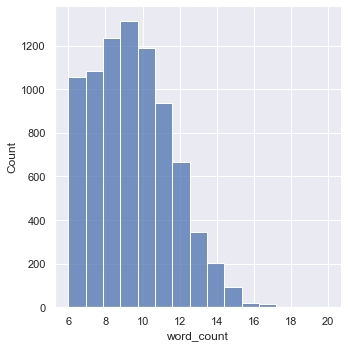

In [26]:
bins = len(set(X_train['word_count']))
sns.displot(x='word_count', data=X_train, bins=bins)
plt.tight_layout();

## Transforming text into vectors

In [27]:
params = {
    'tokenizer': {'num_words': None,
                  'oov_token': '<UNK>'},
    'pad_sequences': {'maxlen': 20,
                      'padding': 'post',
                      'truncating': 'post'},
}

tokenizer = Tokenizer(**params['tokenizer'])
tokenizer.fit_on_texts(X_train['text'].values)
word_index = tokenizer.word_index

X_train_sequences = tokenizer.texts_to_sequences(X_train['text'].values)
X_train_padded = pad_sequences(X_train_sequences, **params['pad_sequences'])

X_test_sequences = tokenizer.texts_to_sequences(X_test['text'].values)
X_test_padded = pad_sequences(X_test_sequences, **params['pad_sequences'])

## Preparing labels

In [28]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

target_names = le.classes_

In [29]:
# Sanity check
print(X_train_padded.shape, y_train.shape, X_test_padded.shape, y_test.shape, target_names)

(8155, 20) (8155,) (2039, 20) (2039,) ['negative' 'neutral' 'positive']


## Training and evaluating the model

In [30]:
np.random.seed(0)
tf.random.set_seed(0)
tf.keras.backend.clear_session()

vocab_size = len(word_index) + 1
embedding_dim = 64

classifier = tf.keras.models.Sequential([
             tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                       input_length=X_train_padded.shape[1]),
    
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.30, recurrent_dropout=0.30)),

             tf.keras.layers.Dense(128, activation='relu'),
             tf.keras.layers.Dense(3, activation='softmax'),
])

classifier.compile(loss='sparse_categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 64)            456320    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 539,267
Trainable params: 539,267
Non-trainable params: 0
_________________________________________________________________


In [31]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_accuracy',
                                         factor=0.5,
                                         mode='max',
                                         patience=4,
                                         verbose=1),
                                         
    tf.keras.callbacks.EarlyStopping('val_accuracy', 
                                     mode='max', 
                                     patience=10, 
                                     verbose=1, 
                                     restore_best_weights=True)
]

class_weight_ = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train), 
                                                  y=y_train)
class_weight_

array([0.46483128, 2.14548803, 2.61378205])

In [32]:
%%time
history = classifier.fit(
    X_train_padded, 
    y_train,
    batch_size=64,
    epochs=10,
    callbacks=callbacks, 
    validation_split=0.2,
    class_weight=class_weight_, # dealing with imbalanced data
    workers=4,
    use_multiprocessing=True);

Train on 6524 samples, validate on 1631 samples
Epoch 1/10
6524/6524 [==============================] - 18s 3ms/sample - loss: 0.6204 - accuracy: 0.7555 - val_loss: 0.5026 - val_accuracy: 0.8075
Epoch 2/10
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.3754 - accuracy: 0.8582 - val_loss: 0.5265 - val_accuracy: 0.8026
Epoch 3/10
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.2514 - accuracy: 0.9134 - val_loss: 0.6046 - val_accuracy: 0.7842
Epoch 4/10
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.1755 - accuracy: 0.9358 - val_loss: 0.7463 - val_accuracy: 0.7805
Epoch 5/10
6464/6524 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9613
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.1153 - accuracy: 0.9614 - val_loss: 0.8514 - val_accuracy: 0.7774
Epoch 6/10
6524/6524 [==============================] -

## Plotting the results

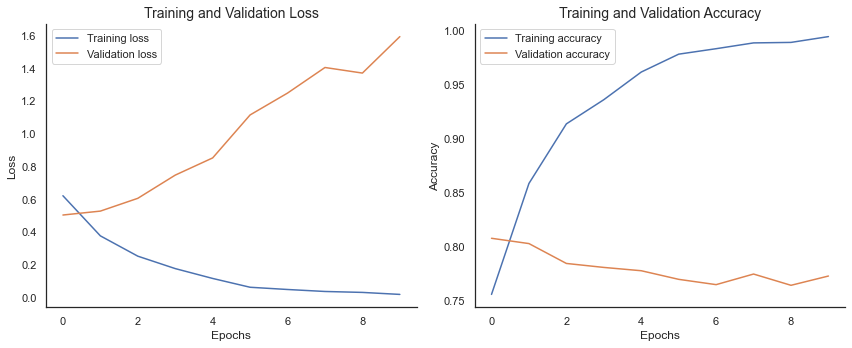

In [33]:
hist = pd.DataFrame(history.history)

sns.set(style='white')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=hist.index, y='loss', data=hist,
             label='Training loss', ax=ax[0])

sns.lineplot(x=hist.index, y='val_loss', data=hist,
             label='Validation loss', ax=ax[0])

ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training and Validation Loss', fontsize=14)

sns.lineplot(x=hist.index, y='accuracy', 
             data=hist, label='Training accuracy', ax=ax[1])

sns.lineplot(x=hist.index, y='val_accuracy', 
             data=hist, label='Validation accuracy', ax=ax[1])

ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].set_title('Training and Validation Accuracy', fontsize=14)

sns.despine()             
plt.tight_layout();

## Evaluating the model

In [34]:
loss, accuracy = classifier.evaluate(X_test_padded, y_test, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 77.29%


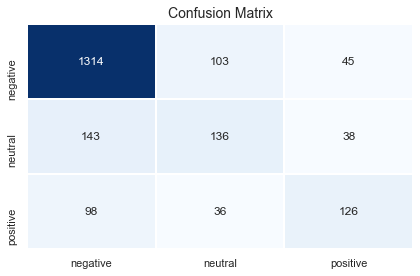

In [35]:
preds = classifier.predict(X_test_padded, batch_size=512).argmax(axis=1)

sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',            
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout();

In [36]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      1462
     neutral       0.49      0.43      0.46       317
    positive       0.60      0.48      0.54       260

    accuracy                           0.77      2039
   macro avg       0.65      0.60      0.62      2039
weighted avg       0.76      0.77      0.76      2039



# Using a pretrained GloVe word embeddings
---

## Preprocessing the embeddings

In [37]:
%%time
# Parse the GloVe word-embeddings file
embeddings_index = {}

with open('glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word   = values[0]
        coefs  = np.array(values[1:], dtype=np.float32)
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')
print('---\n')

# Prepare the GloVe word-embeddings matrix
vocab_size    = len(word_index) + 1
embedding_dim = 200

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(f'Embeddings matrix dimensions: {embeddings_matrix.shape[0]} rows and {embeddings_matrix.shape[1]} columns')

Found 1193514 word vectors.
---

Embeddings matrix dimensions: 7130 rows and 200 columns
Wall time: 1min 35s


## Training the model with a pretrained word embeddings

In [38]:
np.random.seed(0)
tf.random.set_seed(0)
tf.keras.backend.clear_session()

classifier = tf.keras.models.Sequential([
             tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                       input_length=X_train_padded.shape[1],
                                       weights=[embeddings_matrix],
                                       trainable=False),    
            
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.30, recurrent_dropout=0.30)),

             tf.keras.layers.Dense(128, activation='relu'),
             tf.keras.layers.Dense(3, activation='softmax'),
])

classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           1426000   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dense (Dense)                (None, 128)               51328     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,119,315
Trainable params: 693,315
Non-trainable params: 1,426,000
_________________________________________________________________


In [39]:
%%time
history =classifier.fit(
    X_train_padded, 
    y_train,
    batch_size=64,
    epochs=100,
    callbacks=callbacks, 
    validation_split=0.2,
    class_weight=class_weight_, # dealing with imbalanced data
    workers=4,
    use_multiprocessing=True);

Train on 6524 samples, validate on 1631 samples
Epoch 1/100
6524/6524 [==============================] - 11s 2ms/sample - loss: 0.6271 - accuracy: 0.7594 - val_loss: 0.5215 - val_accuracy: 0.8105
Epoch 2/100
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.4940 - accuracy: 0.8035 - val_loss: 0.4961 - val_accuracy: 0.7909
Epoch 3/100
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.4286 - accuracy: 0.8311 - val_loss: 0.4805 - val_accuracy: 0.8105
Epoch 4/100
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.3805 - accuracy: 0.8541 - val_loss: 0.5419 - val_accuracy: 0.8056
Epoch 5/100
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.3357 - accuracy: 0.8640 - val_loss: 0.5700 - val_accuracy: 0.8136
Epoch 6/100
6524/6524 [==============================] - 7s 1ms/sample - loss: 0.2955 - accuracy: 0.8849 - val_loss: 0.5886 - val_accuracy: 0.8020
Epoch 7/100
6524/6524 [==============================] - 7s 1ms/sampl

## Plotting the results

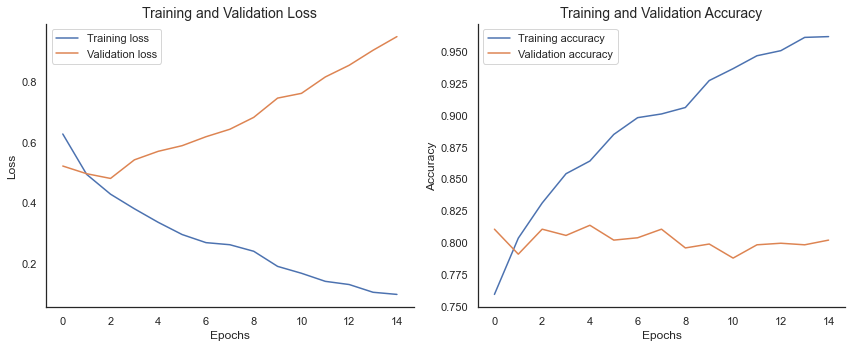

In [40]:
hist = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=hist.index, y='loss', data=hist,
             label='Training loss', ax=ax[0])

sns.lineplot(x=hist.index, y='val_loss', data=hist,
             label='Validation loss', ax=ax[0])

ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training and Validation Loss', fontsize=14)

sns.lineplot(x=hist.index, y='accuracy', 
             data=hist, label='Training accuracy', ax=ax[1])

sns.lineplot(x=hist.index, y='val_accuracy', 
             data=hist, label='Validation accuracy', ax=ax[1])

ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].set_title('Training and Validation Accuracy', fontsize=14)

sns.despine()
plt.tight_layout();

## Evaluating the model

In [41]:
loss, accuracy = classifier.evaluate(X_test_padded, y_test, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 79.35%


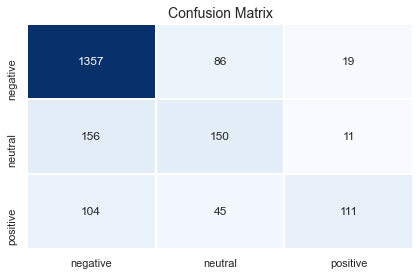

In [42]:
preds = classifier.predict(X_test_padded, batch_size=512).argmax(axis=1)

sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',            
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout();

In [43]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.84      0.93      0.88      1462
     neutral       0.53      0.47      0.50       317
    positive       0.79      0.43      0.55       260

    accuracy                           0.79      2039
   macro avg       0.72      0.61      0.65      2039
weighted avg       0.79      0.79      0.78      2039



# Using a pretrained Word2Vec word embeddings
---

## Preprocessing the embeddings

In [44]:
%%time
# Load pretrained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)
print(f'Found {len(word2vec_model.vocab)} word vectors.')
print('---\n')

# Prepare the Word2Vec word-embeddings matrix
vocab_size    = len(word_index) + 1
embedding_dim = 300

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model:
        embeddings_matrix[i] = word2vec_model[word]
        
embeddings_matrix.shape
print(f'Embeddings matrix dimensions: {embeddings_matrix.shape[0]} rows and {embeddings_matrix.shape[1]} columns')

Found 3000000 word vectors.
---

Embeddings matrix dimensions: 7130 rows and 300 columns
Wall time: 3min 51s


## Training the model with a pretrained word embeddings

In [45]:
np.random.seed(0)
tf.random.set_seed(0)
tf.keras.backend.clear_session()

classifier = tf.keras.models.Sequential([
             tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                       input_length=X_train_padded.shape[1],
                                       weights=[embeddings_matrix],
                                       trainable=False),

             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.30, recurrent_dropout=0.30)),

             tf.keras.layers.Dense(128, activation='relu'),
             tf.keras.layers.Dense(3, activation='softmax'),
])

classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           2139000   
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 128)               76928     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 3,658,715
Trainable params: 1,519,715
Non-trainable params: 2,139,000
_________________________________________________________________


In [46]:
%%time
history =classifier.fit(
    X_train_padded, 
    y_train,
    batch_size=64,
    epochs=100,
    callbacks=callbacks, 
    validation_split=0.2,
    class_weight=class_weight_, # dealing with imbalanced data
    workers=4,
    use_multiprocessing=True);

Train on 6524 samples, validate on 1631 samples
Epoch 1/100
6524/6524 [==============================] - 45s 7ms/sample - loss: 0.6760 - accuracy: 0.7353 - val_loss: 0.5161 - val_accuracy: 0.7750
Epoch 2/100
6524/6524 [==============================] - 8s 1ms/sample - loss: 0.5140 - accuracy: 0.7920 - val_loss: 0.4825 - val_accuracy: 0.8044
Epoch 3/100
6524/6524 [==============================] - 8s 1ms/sample - loss: 0.4564 - accuracy: 0.8208 - val_loss: 0.4767 - val_accuracy: 0.8105
Epoch 4/100
6524/6524 [==============================] - 8s 1ms/sample - loss: 0.4077 - accuracy: 0.8418 - val_loss: 0.5280 - val_accuracy: 0.8112
Epoch 5/100
6524/6524 [==============================] - 8s 1ms/sample - loss: 0.3497 - accuracy: 0.8642 - val_loss: 0.4984 - val_accuracy: 0.8204
Epoch 6/100
6524/6524 [==============================] - 8s 1ms/sample - loss: 0.2956 - accuracy: 0.8849 - val_loss: 0.5774 - val_accuracy: 0.8087
Epoch 7/100
6524/6524 [==============================] - 8s 1ms/sampl

## Plotting the results

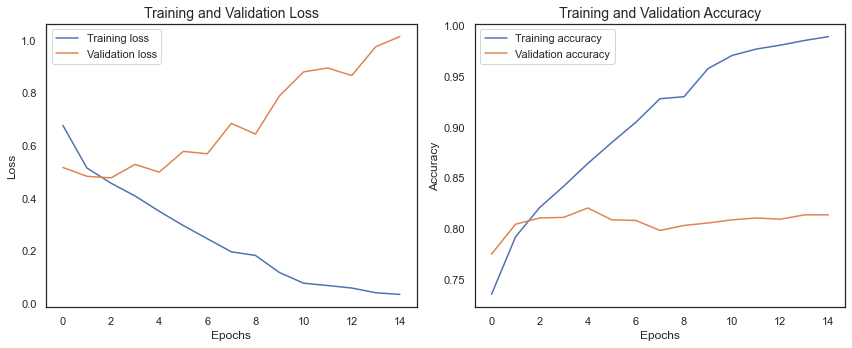

In [47]:
hist = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(x=hist.index, y='loss', data=hist,
             label='Training loss', ax=ax[0])

sns.lineplot(x=hist.index, y='val_loss', data=hist,
             label='Validation loss', ax=ax[0])

ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training and Validation Loss', fontsize=14)

sns.lineplot(x=hist.index, y='accuracy', 
             data=hist, label='Training accuracy', ax=ax[1])

sns.lineplot(x=hist.index, y='val_accuracy', 
             data=hist, label='Validation accuracy', ax=ax[1])

ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].set_title('Training and Validation Accuracy', fontsize=14)
             
plt.tight_layout();

## Evaluating the model

In [48]:
loss, accuracy = classifier.evaluate(X_test_padded, y_test, verbose=0)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 80.28%


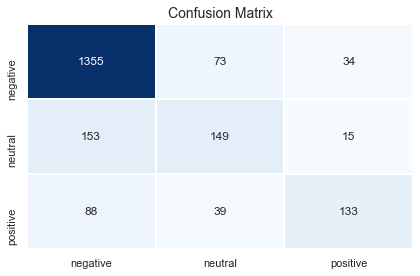

In [49]:
preds = classifier.predict(X_test_padded, batch_size=512).argmax(axis=1)

sns.heatmap(confusion_matrix(y_test, preds),
            cmap='Blues',            
            annot=True,
            fmt='d',
            linewidths=1,
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout();

In [50]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.93      0.89      1462
     neutral       0.57      0.47      0.52       317
    positive       0.73      0.51      0.60       260

    accuracy                           0.80      2039
   macro avg       0.72      0.64      0.67      2039
weighted avg       0.79      0.80      0.79      2039



References:   

[BI MASTER (MBA) - Business Intelligence Master - Sistemas Inteligentes de Apoio à Decisão em Negócios](http://www.cce.puc-rio.br/sitecce/website/website.dll/folder?nCurso=bi-master-buiness-intelligence-master-(traco)-sistemas-inteligentes-de-apoio-a-decisao-em-negocios&nInst=cce)  
[Natural Language Processing with Classification and Vector Spaces](https://www.coursera.org/learn/classification-vector-spaces-in-nlp/home/welcome)   
[Natural Language Processing in TensorFlow](https://www.coursera.org/learn/natural-language-processing-tensorflow/home/welcome)   
[Reproducible Results With Keras](https://deeplizard.com/learn/video/HcW0DeWRggs)   
[Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html)

